In [3]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
from urllib.error import HTTPError
import re
import pandas as pd 
from json import JSONDecodeError
import requests
from sklearn import preprocessing
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from numpy import percentile
import seaborn as sns 
from sklearn.mixture import GaussianMixture

# Part 1 : Data Collection 

In [ ]:
#Retrieving steam IDs of CS:GO players by scraping the pages of the tracker.gg site

i = 1
end_page_num = 500
links = []

while i <= end_page_num:
    try:
        hdr = {'User-Agent':'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36'}
        req = Request("https://tracker.gg/csgo/leaderboards/stats/all/Ties?page={}".format(i), headers = hdr)
        html_page = urlopen(req)
        soup = BeautifulSoup(html_page, "lxml")

        for link in soup.findAll('a'):
            links.append(link.get('href'))
    
        i += 1
    except HTTPError :
        pass

print(links)

In [157]:
#Steam IDs always start with 7656, which allows to isolate addresses with a steam ID
real = []

for i in links: 
    if "7656" in str(i):
        real.append(i) 

In [158]:
#ID Steam Isolation 
id = []

for i in real: 
    id += [int(s) for s in i.split("/")[-2:] if s.isdigit()]

In [7]:
#First test of the API on an identified player in order to get the structure and to do it for all the collected IDs
headers = {"TRN-Api-Key": "6efe7dda-e013-41c9-befc-dd77b9f7b99c"}
s = requests.get("https://public-api.tracker.gg/v2/csgo/standard/profile/steam/76561197961473596", headers=headers)
s.json()

{'data': {'platformInfo': {'platformSlug': 'steam',
   'platformUserId': '76561197961473596',
   'platformUserHandle': 'dank',
   'platformUserIdentifier': '76561197961473596',
   'avatarUrl': 'https://steamcdn-a.akamaihd.net/steamcommunity/public/images/avatars/a4/a41bb81cbe3f138c7c39bd1ad495dc042756d23f_full.jpg',
   'additionalParameters': None},
  'userInfo': {'userId': None,
   'isPremium': False,
   'isVerified': False,
   'isInfluencer': False,
   'isPartner': False,
   'countryCode': None,
   'customAvatarUrl': None,
   'customHeroUrl': None,
   'socialAccounts': None,
   'pageviews': None,
   'isSuspicious': None},
  'metadata': {},
  'segments': [{'type': 'overview',
    'attributes': {},
    'metadata': {'name': 'Lifetime'},
    'expiryDate': '2021-11-22T09:39:08.1530986+00:00',
    'stats': {'timePlayed': {'rank': None,
      'percentile': 77.0,
      'displayName': 'Time Played',
      'displayCategory': 'General',
      'category': 'general',
      'metadata': {},
      '

In [8]:
#Structure the dataframe to handle the data from the collected ID steams

allstat = s.json()['data']["segments"][0]["stats"]
col = ["User Id"]
for i in allstat : 
    col.append(allstat[i]['displayName'])

df = pd.DataFrame(columns=col)
df

,User Id,Time Played,Score,Kills,Deaths,K/D,Damage,Headshots,Dominations,Shots Fired,...,Hostages Rescued,MVP,Wins,Ties,Matches Played,Losses,Rounds Played,Rounds Won,Win %,Headshot %


In [9]:
#Retrieve all player data using the tracker.gg API

for i in id: 
    try:
        headers = {"TRN-Api-Key": "6efe7dda-e013-41c9-befc-dd77b9f7b99c"}
        s = requests.get("https://public-api.tracker.gg/v2/csgo/standard/profile/steam/{}".format(i), headers=headers)
        row = [i]
        allstat = s.json()['data']["segments"][0]["stats"]
        for j in allstat: 
            row.append(allstat[j]["displayValue"])
                   
        row_series = pd.Series(row, index = df.columns)
        df = df.append(row_series, ignore_index=True)
    except (KeyError, JSONDecodeError) :
        pass

In [183]:
#Clean the data so that it is only float

for i in df.columns[2:] :
    df[i] = df[i].str.replace(",","") 
    df[i] = df[i].str.replace("%","")
    df[i] = df[i].astype("float")

In [184]:
#Remove IDs and game time as they are not usable or useful and save the dataset so that it is not lost 
data = df.iloc[:,2:]
data.to_csv()

# Part 2 : Model Testing 

In [4]:
#Use of the previously saved dataset
 
df = pd.read_csv('/Users/christophesanchis/memoire.csv', delimiter=";")
data = df.iloc[:,1:]
pd.set_option("display.max_columns", None)
data

,Score,Kills,Deaths,K/D,Damage,Headshots,Dominations,Shots Fired,Shots Hit,Shots Accuracy,Snipers Killed,Domination Overkills,Domination Revenges,Bombs Planted,Bombs Defused,Money Earned,Hostages Rescued,MVP,Wins,Ties,Matches Played,Losses,Rounds Played,Rounds Won,Win %,Headshot %
0,90825.0,64010.0,43415.0,1.47,5469199.0,30791.0,159.0,445411.0,92913.0,20.9,2239.0,301.0,51.0,1215.0,494.0,120178269.0,501.0,9954.0,12583.0,5412.0,25228.0,12645.0,33252.0,12583.0,49.9,48.1
1,37177.0,23354.0,16610.0,1.41,12424189.0,5104.0,2956.0,2156088.0,1385405.0,64.3,51307.0,4501.0,2730.0,5511.0,4118.0,121303156.0,807.0,1626.0,6675.0,4526.0,11486.0,4811.0,940768.0,6675.0,58.1,21.9
2,175099.0,377607.0,340137.0,1.11,11308366.0,66327.0,218.0,1022660.0,591692.0,57.9,6441.0,399.0,45.0,18674.0,13132.0,204974250.0,531.0,46023.0,9038.0,2302.0,24565.0,15527.0,66608.0,9038.0,36.8,17.6
3,20899.0,206371.0,16340.0,12.63,8809755.0,13478.0,34534577.0,216841.0,98468.0,45.4,3454196.0,8695.0,6143.0,2145533.0,631289.0,81229991.0,93455.0,2180.0,274.0,2143.0,565.0,291.0,11783.0,274.0,48.5,6.5
4,54966.0,18610.0,27416.0,0.68,2430503.0,5269.0,2141.0,294100.0,73146.0,24.9,4362.0,2146.0,2145.0,2200.0,2176.0,97599397.0,2138.0,3346.0,2251.0,2137.0,2452.0,201.0,24016.0,2251.0,91.8,28.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7258,179769.0,80723.0,89615.0,0.90,11831693.0,39396.0,71.0,1831611.0,270998.0,14.8,3505.0,154.0,20.0,5041.0,965.0,269238350.0,8.0,7897.0,1656.0,0.0,3498.0,1842.0,93464.0,1656.0,47.3,48.8
7259,79560.0,37071.0,28097.0,1.32,5610044.0,13123.0,88.0,516516.0,103898.0,20.1,2736.0,235.0,13.0,1003.0,455.0,76601650.0,4.0,6298.0,734.0,0.0,1494.0,760.0,34299.0,734.0,49.1,35.4
7260,51386.0,12197.0,10332.0,1.18,1775002.0,4244.0,134.0,291859.0,46169.0,15.8,1144.0,138.0,66.0,594.0,87.0,27413450.0,8.0,1061.0,201.0,0.0,468.0,267.0,9163.0,201.0,42.9,34.8
7261,74422.0,30576.0,34824.0,0.88,4397890.0,13166.0,46.0,563504.0,116398.0,20.7,2308.0,20.0,17.0,2038.0,381.0,119979500.0,6.0,3623.0,746.0,0.0,1760.0,1014.0,40277.0,746.0,42.4,43.1


In [5]:
data.columns

Index(['Score', 'Kills', 'Deaths', 'K/D', 'Damage', 'Headshots', 'Dominations',
       'Shots Fired', 'Shots Hit', 'Shots Accuracy', 'Snipers Killed',
       'Domination Overkills', 'Domination Revenges', 'Bombs Planted',
       'Bombs Defused', 'Money Earned', 'Hostages Rescued', 'MVP', 'Wins',
       'Ties', 'Matches Played', 'Losses', 'Rounds Played', 'Rounds Won',
       'Win %', 'Headshot %'],
      dtype='object')

In [6]:
#Variables of particular interest to us for detecting cheaters 
data_clustering = data[["K/D", "Shots Accuracy", "Headshot %"]]
data_clustering

,K/D,Shots Accuracy,Headshot %
0,1.47,20.9,48.1
1,1.41,64.3,21.9
2,1.11,57.9,17.6
3,12.63,45.4,6.5
4,0.68,24.9,28.3
...,...,...,...
7258,0.90,14.8,48.8
7259,1.32,20.1,35.4
7260,1.18,15.8,34.8
7261,0.88,20.7,43.1


In [7]:
#Min Max Scaler in preprocessing to have a correct scaling before using the variables for clustering

data_clustering_values = data_clustering.values
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(data_clustering_values)
data_clustering_scaled = pd.DataFrame(x_scaled,
columns=data_clustering.columns)


## 2.1. Model 1 : K-Means 

/Users/christophesanchis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/christophesanchis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


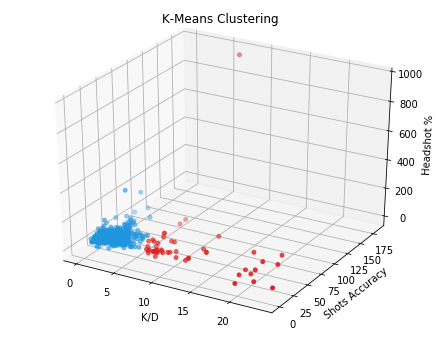

In [26]:
#KMeans Model and Plotting the clustering

colors = ['#DF2020', '#2095DF']

kmeans = KMeans(2)

data_clustering["cluster"] = kmeans.fit_predict(data_clustering_scaled)
data_clustering['c'] = data_clustering.cluster.map({0:colors[1], 1:colors[0]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(data_clustering["K/D"], 
           data_clustering["Shots Accuracy"], 
           data_clustering["Headshot %"], 
           c=data_clustering.c, s=15)
ax.set_xlabel("K/D")
ax.set_ylabel("Shots Accuracy")
ax.set_zlabel("Headshot %")
ax.set_title("K-Means Clustering", pad=10)
plt.show()

In [9]:
#Detailed data of the players being in the cluster 1 (i.e. those of the potential cheaters)

#pd.set_option("display.max_rows", None)
data_clustering[data_clustering['cluster'] == 1]

,K/D,Shots Accuracy,Headshot %,cluster,c
3,12.63,45.4,6.5,1,#DF2020
13,12.63,45.4,6.5,1,#DF2020
22,11.71,26.6,5.0,1,#DF2020
36,19.51,2.4,6.7,1,#DF2020
46,18.66,32.4,1.0,1,#DF2020
59,6.67,77.7,40.4,1,#DF2020
64,8.99,30.5,2.5,1,#DF2020
79,9.52,20.6,36.8,1,#DF2020
214,11.74,21.3,8.9,1,#DF2020
402,6.73,182.9,952.5,1,#DF2020


Text(0.5, 1.0, 'Cluster repartition in percentage')

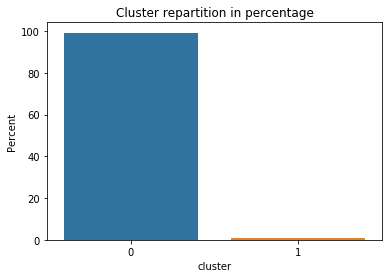

In [10]:
#Plot Cluster repartition in percentage

ax = sns.barplot(x='cluster', y='cluster', data=data_clustering, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel= "Percent")
ax.set_title("Cluster repartition in percentage")

In [11]:
#Number and pourcentage of players contained in cluster 1 and 2 
for i in data_clustering['cluster'].unique(): 
    print("Number of players in the cluster {num} :".format(num=i), 
          len(data_clustering[data_clustering['cluster'] == i]))
    print("Percentage of players in the cluster {num} :".format(num=i), 
          round(len(data_clustering[data_clustering['cluster'] == i]) / len(data_clustering) * 100,3), "%")

Number of players in the cluster 0 : 7211
Percentage of players in the cluster 0 : 99.284 %
Number of players in the cluster 1 : 52
Percentage of players in the cluster 1 : 0.716 %


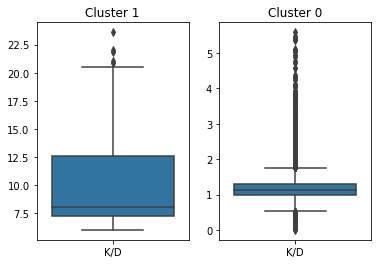

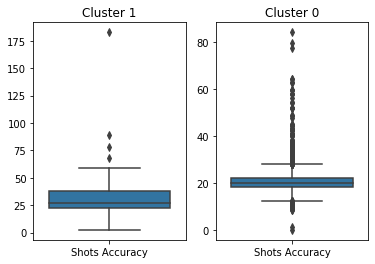

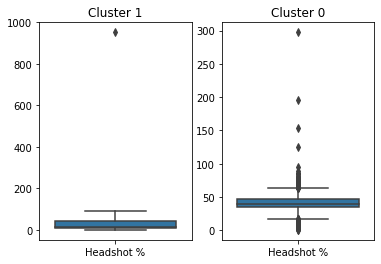

In [12]:
#Plot boxplot for each column and cluster
for i in data_clustering[["K/D","Shots Accuracy", "Headshot %"]].columns:
    fig, axes = plt.subplots(1, 2)
    sns.boxplot(ax=axes[0], data=data_clustering[data_clustering['cluster'] == 1][[i]])
    axes[0].set_title("Cluster 1")
    sns.boxplot(ax=axes[1], data=data_clustering[data_clustering['cluster'] == 0][[i]])
    axes[1].set_title("Cluster 0")
   

In [25]:
#Calculate the 5-number summary and mean for each column and each cluster

for i in data_clustering[["K/D","Shots Accuracy", "Headshot %"]].columns : 
    for j in [0,1]:
        quartiles = percentile(data_clustering[data_clustering['cluster'] == j][i], [25, 50, 75])
        data_min, data_max = data_clustering[data_clustering['cluster'] == j][i].min(), data_clustering[data_clustering['cluster'] == j][i].max()
        data_mean = data_clustering[data_clustering['cluster'] == j][i].mean()
        print("5-number summary and mean for {col} in the cluster {cluster}".format(col=i, cluster=j))
        print('Min: %.3f' % data_min)
        print('Q1: %.3f' % quartiles[0])
        print('Median: %.3f' % quartiles[1])
        print('Q3: %.3f' % quartiles[2])
        print('Max: %.3f' % data_max)
        print('Mean: %.3f' % data_mean)
        print('\n')

5-number summary and mean for K/D in the cluster 0
Min: 0.090
Q1: 0.980
Median: 1.110
Q3: 1.280
Max: 2.250
Mean: 1.145


5-number summary and mean for K/D in the cluster 1
Min: 0.000
Q1: 2.050
Median: 2.560
Q3: 3.635
Max: 23.590
Mean: 3.638


5-number summary and mean for Shots Accuracy in the cluster 0
Min: 8.500
Q1: 18.200
Median: 20.000
Q3: 21.900
Max: 32.200
Mean: 20.113


5-number summary and mean for Shots Accuracy in the cluster 1
Min: 0.100
Q1: 21.600
Median: 26.100
Q3: 32.450
Max: 182.900
Mean: 29.288


5-number summary and mean for Headshot % in the cluster 0
Min: 2.500
Q1: 34.500
Median: 39.800
Q3: 46.000
Max: 76.400
Mean: 40.640


5-number summary and mean for Headshot % in the cluster 1
Min: 0.000
Q1: 22.200
Median: 40.100
Q3: 55.200
Max: 952.500
Mean: 43.675




## 2.2. Model 2 : GaussianMixture

/Users/christophesanchis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/christophesanchis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


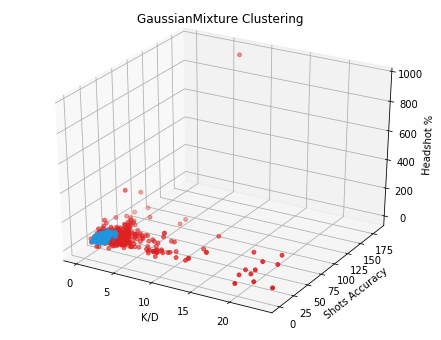

In [15]:
#GaussianMixture Model and Plotting the clusters 

colors = ['#DF2020', '#2095DF']

gauss = GaussianMixture(n_components=2)

data_clustering["cluster"] = gauss.fit_predict(data_clustering_scaled)
data_clustering['c'] = data_clustering.cluster.map({0:colors[1], 1:colors[0]})
fig = plt.figure(figsize=(26,6))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(data_clustering["K/D"], 
           data_clustering["Shots Accuracy"], 
           data_clustering["Headshot %"], 
           c=data_clustering.c, s=15)
ax.set_xlabel("K/D")
ax.set_ylabel("Shots Accuracy")
ax.set_zlabel("Headshot %")
ax.set_title("GaussianMixture Clustering", pad=10)
plt.show()



In [16]:
#Detailed data of the players being in the cluster 1 (i.e. those of the potential cheaters)

#pd.set_option("display.max_rows", None)
data_clustering[data_clustering['cluster'] == 1]

,K/D,Shots Accuracy,Headshot %,cluster,c
1,1.41,64.3,21.9,1,#DF2020
2,1.11,57.9,17.6,1,#DF2020
3,12.63,45.4,6.5,1,#DF2020
6,1.47,59.4,55.1,1,#DF2020
7,2.58,42.4,27.8,1,#DF2020
...,...,...,...,...,...
7028,3.53,18.2,24.2,1,#DF2020
7068,2.67,22.3,35.3,1,#DF2020
7142,0.05,36.4,78.7,1,#DF2020
7164,2.17,19.0,42.6,1,#DF2020


Text(0.5, 1.0, 'Cluster repartition in percentage')

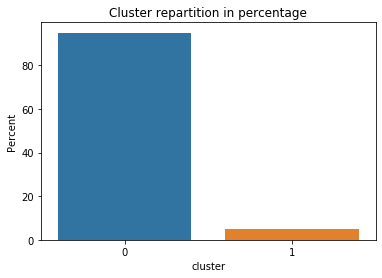

In [17]:
#Plot Cluster repartition in percentage

ax = sns.barplot(x='cluster', y='cluster', data=data_clustering, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel= "Percent")
ax.set_title("Cluster repartition in percentage")

In [18]:
#Number and pourcentage of players contained in cluster 1 and 2 

for i in data_clustering['cluster'].unique(): 
    print("Number of players in the cluster {num} :".format(num=i), 
          len(data_clustering[data_clustering['cluster'] == i]))
    print("Percentage of players in the cluster {num} :".format(num=i), 
          round(len(data_clustering[data_clustering['cluster'] == i]) / len(data_clustering) * 100,3), "%")

Number of players in the cluster 0 : 6900
Percentage of players in the cluster 0 : 95.002 %
Number of players in the cluster 1 : 363
Percentage of players in the cluster 1 : 4.998 %


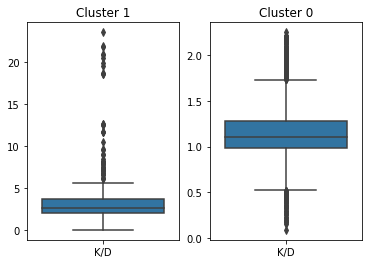

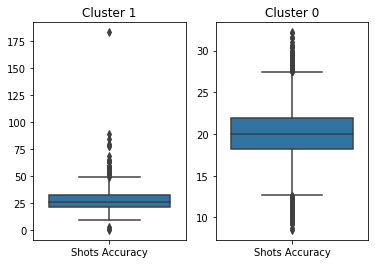

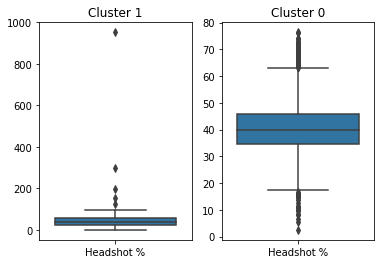

In [19]:
#Plot boxplot for each column and cluster

for i in data_clustering[["K/D","Shots Accuracy", "Headshot %"]].columns:
    fig, axes = plt.subplots(1, 2)
    sns.boxplot(ax=axes[0], data=data_clustering[data_clustering['cluster'] == 1][[i]])
    axes[0].set_title("Cluster 1")
    sns.boxplot(ax=axes[1], data=data_clustering[data_clustering['cluster'] == 0][[i]])
    axes[1].set_title("Cluster 0")
   

In [20]:
#Calculate the 5-number summary and mean for each column and each cluster

for i in data_clustering[["K/D","Shots Accuracy", "Headshot %"]].columns : 
    for j in [0,1]:
        quartiles = percentile(data_clustering[data_clustering['cluster'] == j][i], [25, 50, 75])
        data_min, data_max = data_clustering[data_clustering['cluster'] == j][i].min(), data_clustering[data_clustering['cluster'] == j][i].max()
        data_mean = data_clustering[data_clustering['cluster'] == j][i].mean()
        print("5-number summary and mean for {col} in the cluster {cluster}".format(col=i, cluster=j))
        print('Min: %.3f' % data_min)
        print('Q1: %.3f' % quartiles[0])
        print('Median: %.3f' % quartiles[1])
        print('Q3: %.3f' % quartiles[2])
        print('Max: %.3f' % data_max)
        print('Mean: %.3f' % data_mean)
        print('\n')

5-number summary and mean for K/D in the cluster 0
Min: 0.090
Q1: 0.980
Median: 1.110
Q3: 1.280
Max: 2.250
Mean: 1.145


5-number summary and mean for K/D in the cluster 1
Min: 0.000
Q1: 2.050
Median: 2.560
Q3: 3.635
Max: 23.590
Mean: 3.638


5-number summary and mean for Shots Accuracy in the cluster 0
Min: 8.500
Q1: 18.200
Median: 20.000
Q3: 21.900
Max: 32.200
Mean: 20.113


5-number summary and mean for Shots Accuracy in the cluster 1
Min: 0.100
Q1: 21.600
Median: 26.100
Q3: 32.450
Max: 182.900
Mean: 29.288


5-number summary and mean for Headshot % in the cluster 0
Min: 2.500
Q1: 34.500
Median: 39.800
Q3: 46.000
Max: 76.400
Mean: 40.640


5-number summary and mean for Headshot % in the cluster 1
Min: 0.000
Q1: 22.200
Median: 40.100
Q3: 55.200
Max: 952.500
Mean: 43.675


